# Zadania

Zaimplementuj w **PyTorch** następujące modele sieci rekurencyjnych:
- **Simple RNN**
- **LSTM**
- **BiLSTM**
- **GRU**
- **BiGRU**

Dla każdego typu sieci zaproponuj **po dwie różne architektury** (np. różniące się liczbą warstw, rozmiarem warstw ukrytych, dropoutem itp.). W procesie uczenia wykorzystaj mechanizm **Early Stopping** oparty na **Validation Loss**.

Skorzystaj z poniższego **datasetu** do trenowania i ewaluacji modeli. Wykorzystaj dataset dołączony do zadania oraz zapoznaj sie z bilbioteka TorchText i wybierz dataset (https://pytorch.org/text/stable/index.html) np. AmazonReview, YelpReviewFull czy YahooAnswers.

Finalnie zadanie ma być wykonane na dwóch datasetach!

## Analiza i prezentacja wyników

W ramach analizy i prezentacji wyników wykonaj następujące kroki:

1. **Wizualizacje metryk na przestrzeni epok**:
   - Wykresy **Train Accuracy** i **Validation Accuracy**,
   - Wykresy **Train F1-Score** i **Validation F1-Score**,
   - Po zakończeniu uczenia przedstaw **Test Accuracy** i **Test F1-Score** dla najlepszego modelu.

2. **Wizualizacje danych**:
   - Przed i po procesie **clean-up** danych tekstowych przedstaw:
     - Przykładowe **n-gramy** (np. bigramy, trigramy),
     - Wizualizacje **WordCloud** dla danych surowych i oczyszczonych.

3. **Eksperymenty**:
   - Uruchom każdy model **minimum 3 razy** (z różnymi inicjalizacjami wag),
   - Dla każdej architektury przedstaw wyniki (**Accuracy**, **F1-Score**) po ostatniej najlepszej epoce przed zadziałaniem **Early Stoppingu**.

4. **Porównanie z modelem bazowym**:
   - Porównaj wyniki uzyskane z powyższych modeli z wynikami modelu klasyfikacji tekstu opartego na **Word Embedding** (np. z Lab01, wykorzystując statyczne embeddingi typu GloVe lub word2vec).

5. **Wnioski**:
   - Przeanalizuj i podsumuj, która architektura sieci (**Simple RNN**, **LSTM**, **BiLSTM**, **GRU**, **BiGRU**) sprawuje się najlepiej na danym zbiorze danych, uwzględniając metryki **Accuracy** i **F1-Score** oraz stabilność wyników.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import bigrams, trigrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


# Ustawienie GPU, jeśli jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...


Używane urządzenie: cuda


[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [10]:
#Wczytanie datasetu
df = pd.read_csv('amazon_reviews.csv')
print(f"Dataset shape: {df.shape}")
print(f"Dataset Types: {df.dtypes}")
print(f"Cleaned reviews: {df['cleaned_review']}")
print(df.head())

Dataset shape: (17340, 4)
Dataset Types: sentiments                object
cleaned_review            object
cleaned_review_length      int64
review_score             float64
dtype: object
Cleaned reviews: 0        i wish would have gotten one earlier love it a...
1        i ve learned this lesson again open the packag...
2                it is so slow and lags find better option
3        roller ball stopped working within months of m...
4        i like the color and size but it few days out ...
                               ...                        
17335    i love this speaker and love can take it anywh...
17336    i use it in my house easy to connect and loud ...
17337    the bass is good and the battery is amazing mu...
17338                                              love it
17339                                         mono speaker
Name: cleaned_review, Length: 17340, dtype: object
  sentiments                                     cleaned_review  \
0   positive  i wish would ha

In [12]:
#Funkcja wizualizacyjna
# Function for n-gram and word cloud visualization
def visualize_text_features(text_series, title_prefix=""):
    
    all_text = text_series
    
    # Get bigrams and trigrams
    bi_grams = list(bigrams(all_text.split()))
    tri_grams = list(trigrams(all_text.split()))
    
    # Calculate frequency distributions
    bi_fdist = FreqDist(bi_grams)
    tri_fdist = FreqDist(tri_grams)
    
    # Get top 15 bigrams and trigrams
    top_bi = bi_fdist.most_common(15)
    top_tri = tri_fdist.most_common(15)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    # Visualize
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot word cloud
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].set_title(f"{title_prefix} Word Cloud")
    axes[0].axis('off')
    
    # Plot bigrams
    sns.barplot(x=[' '.join(bg[0]) for bg in top_bi], y=[bg[1] for bg in top_bi], ax=axes[1])
    axes[1].set_title(f"{title_prefix} Top 15 Bigrams")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    # Plot trigrams
    sns.barplot(x=[' '.join(tg[0]) for tg in top_tri], y=[tg[1] for tg in top_tri], ax=axes[2])
    axes[2].set_title(f"{title_prefix} Top 15 Trigrams")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [31]:
# Preprocesowanie i połączenie tekstu
def preprocess_and_concatenate(df, column_name):

    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None

    if df[column_name].empty:
        print(f"Column '{column_name}' is empty.")
        return None

    stop_words = set(stopwords.words('english'))
    processed_texts = []

    for text in df[column_name].astype(str):  # Ensure string type
        words = word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalnum()] #lower case and remove non alphanumeric
        processed_texts.append(" ".join(filtered_words))

    concatenated_string = "".join(processed_texts)
    return concatenated_string, processed_texts

C:\Users\Jan\AppData\Local\Temp\ipykernel_2788\3266804556.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Jan\AppData\Local\Temp\ipykernel_2788\3266804556.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


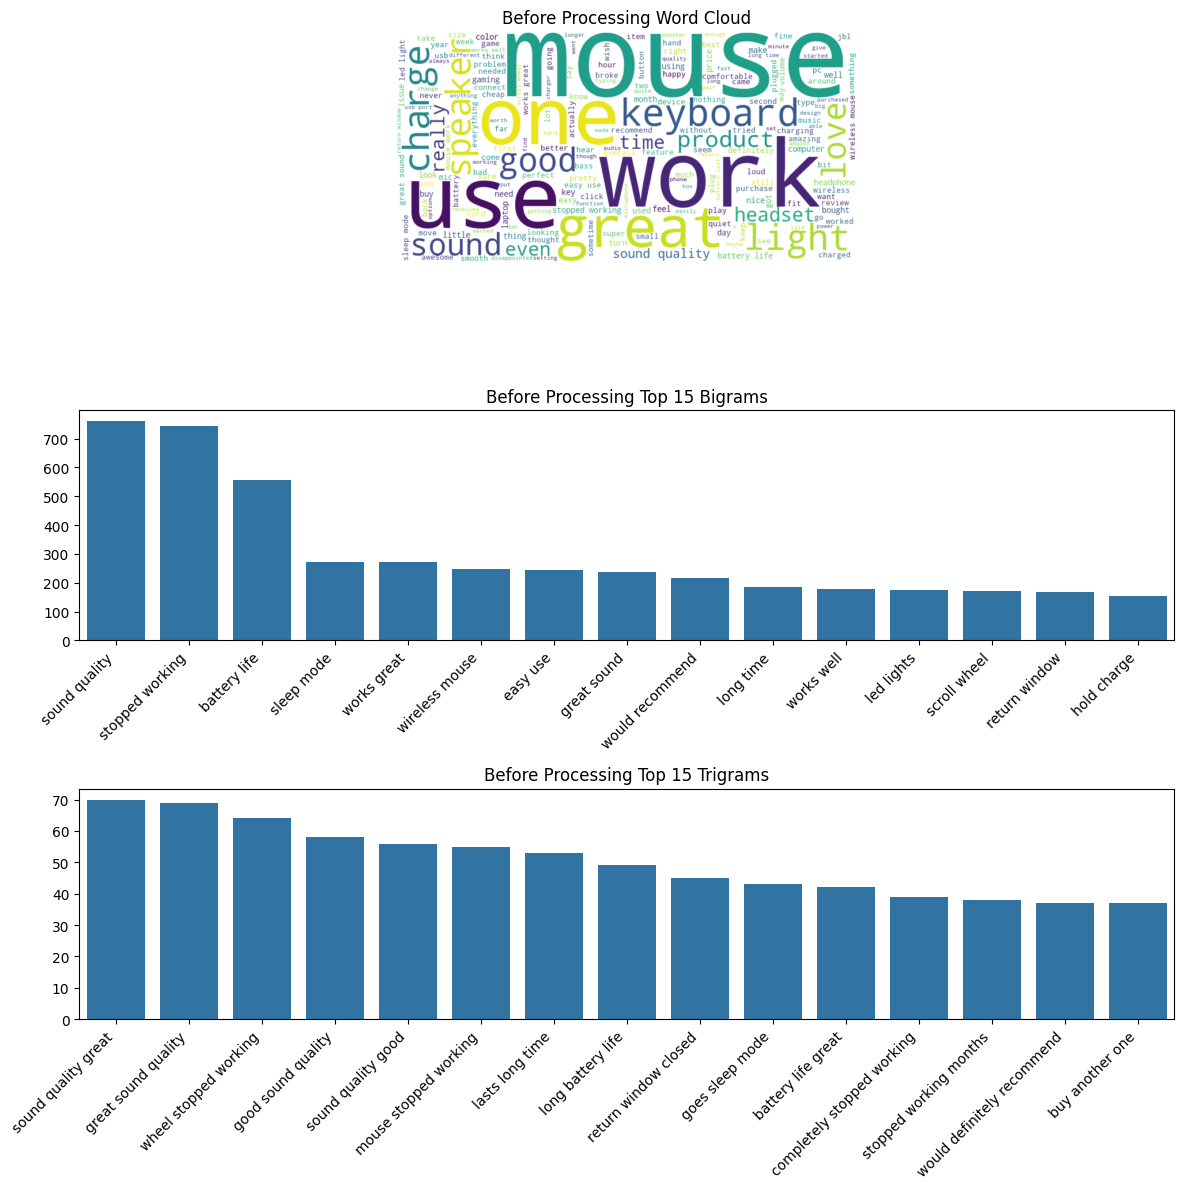

In [32]:
#Wizualizacja przed czyszczeniem
processed_string, processed_text_array = preprocess_and_concatenate(df, 'cleaned_review')
visualize_text_features(processed_string, "Before Processing")

In [21]:
# Enkodowanie sentymentów
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiments'])


In [23]:
# Budowa słownika
def build_vocab(texts):
    word_set = set()
    for text in texts:
        for word in text.split():
            word_set.add(word)
    word_to_idx = {word: i+1 for i, word in enumerate(word_set)}  # 0 is reserved for padding
    return word_to_idx

word_to_idx = build_vocab(processed_string)
vocab_size = len(word_to_idx) + 1  # +1 for padding
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 27


In [24]:
# Convert text to sequences of indices
def text_to_sequence(text, word_to_idx, max_length=None):
    sequence = [word_to_idx.get(word, 0) for word in text.split()]
    if max_length:
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + [0] * (max_length - len(sequence))
    return sequence

# Determine maximum sequence length (can be set to a specific value if needed)
max_length = int(df['cleaned_review_length'].quantile(0.95))  # Using 95th percentile to avoid outliers
print(f"Maximum sequence length: {max_length}")

Maximum sequence length: 92


In [25]:
# Create PyTorch dataset
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_length):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Convert text to sequence
        sequence = text_to_sequence(text, self.word_to_idx, self.max_length)
        
        return {
            'text': torch.tensor(sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [33]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    processed_text_array, df['encoded_sentiment'].values, 
    test_size=0.3, random_state=42, stratify=df['encoded_sentiment'].values
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, 
    test_size=0.5, random_state=42, stratify=temp_labels
)

# Create datasets
train_dataset = ReviewDataset(train_texts, train_labels, word_to_idx, max_length)
val_dataset = ReviewDataset(val_texts, val_labels, word_to_idx, max_length)
test_dataset = ReviewDataset(test_texts, test_labels, word_to_idx, max_length)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [27]:
# Definicja modeli
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden.squeeze(0))

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        return self.fc(hidden.squeeze(0))

class BiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BiGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

In [28]:
#Funkcja treningowa
def train_model(model, train_loader, val_loader, optimizer, criterion, device, n_epochs=10, patience=3):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)
                
                predictions = model(texts)
                loss = criterion(predictions, labels)
                
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load('best_model.pt'))
    
    return model, train_losses, val_losses


In [29]:
#Funkcja evaluacyjna
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            test_loss += loss.item()
            
            predicted_labels = torch.argmax(predictions, dim=1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
    
    return test_loss, accuracy, report

In [34]:
#Trenowanie modeli
# Model hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)
learning_rate = 0.001
n_epochs = 20
patience = 3

# List of models to train
models = {
    'SimpleRNN': SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim),
    'LSTM': LSTM(vocab_size, embedding_dim, hidden_dim, output_dim),
    'BiLSTM': BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim),
    'GRU': GRU(vocab_size, embedding_dim, hidden_dim, output_dim),
    'BiGRU': BiGRU(vocab_size, embedding_dim, hidden_dim, output_dim)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    trained_model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, 
        device, n_epochs=n_epochs, patience=patience
    )
    
    test_loss, accuracy, report = evaluate_model(trained_model, test_loader, criterion, device)
    
    results[model_name] = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'report': report,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    print(f"{model_name} Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")


Training SimpleRNN...
Epoch: 1, Train Loss: 0.9266, Val Loss: 0.9204
Epoch: 2, Train Loss: 0.9176, Val Loss: 0.9148
Epoch: 3, Train Loss: 0.9183, Val Loss: 0.9164
Epoch: 4, Train Loss: 0.9163, Val Loss: 0.9153
Epoch: 5, Train Loss: 0.9176, Val Loss: 0.9143
Epoch: 6, Train Loss: 0.9154, Val Loss: 0.9182
Epoch: 7, Train Loss: 0.9156, Val Loss: 0.9179
Epoch: 8, Train Loss: 0.9161, Val Loss: 0.9133
Epoch: 9, Train Loss: 0.9145, Val Loss: 0.9167
Epoch: 10, Train Loss: 0.9158, Val Loss: 0.9145
Epoch: 11, Train Loss: 0.9151, Val Loss: 0.9166
Early stopping after 11 epochs.
SimpleRNN Test Loss: 0.9120, Accuracy: 0.5483
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.

c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 1, Train Loss: 0.9175, Val Loss: 0.9131
Epoch: 2, Train Loss: 0.9131, Val Loss: 0.9138
Epoch: 3, Train Loss: 0.9131, Val Loss: 0.9173
Epoch: 4, Train Loss: 0.9139, Val Loss: 0.9134
Early stopping after 4 epochs.
LSTM Test Loss: 0.9119, Accuracy: 0.5483
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.55      0.39      2601


Training BiLSTM...


c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 1, Train Loss: 0.9206, Val Loss: 0.9181
Epoch: 2, Train Loss: 0.9148, Val Loss: 0.9178
Epoch: 3, Train Loss: 0.9147, Val Loss: 0.9150
Epoch: 4, Train Loss: 0.9148, Val Loss: 0.9132
Epoch: 5, Train Loss: 0.9132, Val Loss: 0.9149
Epoch: 6, Train Loss: 0.9137, Val Loss: 0.9136
Epoch: 7, Train Loss: 0.9131, Val Loss: 0.9129
Epoch: 8, Train Loss: 0.9127, Val Loss: 0.9132
Epoch: 9, Train Loss: 0.9134, Val Loss: 0.9133
Epoch: 10, Train Loss: 0.9126, Val Loss: 0.9137
Early stopping after 10 epochs.
BiLSTM Test Loss: 0.9117, Accuracy: 0.5483
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.55      0.39      2601


Training GRU...


c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 1, Train Loss: 0.9219, Val Loss: 0.9130
Epoch: 2, Train Loss: 0.9170, Val Loss: 0.9220
Epoch: 3, Train Loss: 0.9162, Val Loss: 0.9130
Epoch: 4, Train Loss: 0.9154, Val Loss: 0.9136
Epoch: 5, Train Loss: 0.9157, Val Loss: 0.9156
Epoch: 6, Train Loss: 0.9143, Val Loss: 0.9145
Early stopping after 6 epochs.
GRU Test Loss: 0.9118, Accuracy: 0.5483
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.55      0.39      2601


Training BiGRU...


c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Epoch: 1, Train Loss: 0.9283, Val Loss: 0.9349
Epoch: 2, Train Loss: 0.9183, Val Loss: 0.9139
Epoch: 3, Train Loss: 0.9155, Val Loss: 0.9208
Epoch: 4, Train Loss: 0.9168, Val Loss: 0.9195
Epoch: 5, Train Loss: 0.9147, Val Loss: 0.9207
Early stopping after 5 epochs.
BiGRU Test Loss: 0.9126, Accuracy: 0.5483
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.55      0.39      2601



c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita